In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchdiffeq import odeint
from torch.nn.parameter import Parameter
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal

import gpytorch

from reggae.data_loaders import load_barenco_puma, DataHolder

from matplotlib import pyplot as plt

import numpy as np

f64 = np.float64

torch.Size([3, 5, 7])
tensor([[0.0000],
        [0.1667],
        [0.3333],
        [0.5000],
        [0.6667],
        [0.8333],
        [1.0000]], dtype=torch.float64)


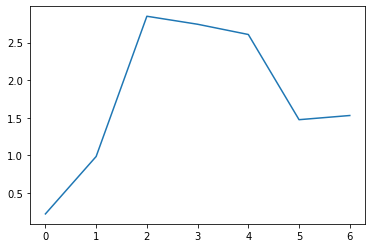

In [2]:
m_observed, f_observed, σ2_m_pre, σ2_f_pre, t = load_barenco_puma('../data/')

m_df, m_observed = m_observed
f_df, f_observed = f_observed
# Shape of m_observed = (replicates, genes, times)
m_observed = torch.tensor(m_observed)
f_observed = torch.tensor(f_observed)
data = (m_observed, f_observed)

σ2_m_pre = f64(σ2_m_pre)
σ2_f_pre = f64(σ2_f_pre)
noise_data = (σ2_m_pre, σ2_f_pre)

print(m_observed.shape)

num_genes = m_observed.shape[1]
num_tfs = f_observed.shape[1]
N_m = m_observed.shape[2]
granularity = 100
t_start = f64(0)
t_end = f64(1)
t = torch.linspace(t_start, t_end, granularity, dtype=torch.float64).view((-1, 1))
t_inducing = torch.linspace(t_start, t_end, 7, dtype=torch.float64).reshape((-1, 1))
print(t_inducing)
plt.plot(m_observed[0,0])

In [17]:
def positivity_transform(value):
    return torch.log(1+torch.exp(value))

def plot_genes():
    initial_value = torch.zeros((num_genes, 1), dtype=torch.float64) #, dtype=torch.float64
    outputs, _ = model(t.view(-1), initial_value)
    outputs = torch.squeeze(outputs)
    print(outputs.shape)
    plt.figure(figsize=(5, 8))
    for i in range(num_genes):
        plt.subplot(511+i)
        plt.plot(t, torch.squeeze(outputs[0]).detach())
        plt.scatter(t_inducing, m_observed[0][i])

def plot_tfs():
    plt.figure(figsize=(5, 3))
    t_predict = torch.linspace(0, 1, 80)
    tfs = model.get_tfs(t_predict)
    print(tfs.shape)
    plt.plot(t_predict, tfs[0].detach())
    plt.title('Latent')

In [88]:
# class GP(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, num_tfs):
#         likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tfs)
#         super(GP, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_tfs]))
#         rbf = gpytorch.kernels.RBFKernel(eps=0.15, batch_shape=torch.Size([num_tfs])) # eps is min lengthscale
#         rbf.lengthscale = f64(0.2)
#         self.covar_module = gpytorch.kernels.ScaleKernel(rbf, batch_shape=torch.Size([num_tfs]))
#
#
#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
#             gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
#         )


class ODEModel(nn.Module):
    """
    Description blah
    Parameters
    ----------
    num_genes : int
    Number of genes.
    num_tfs : int

    t_inducing : int
    inducing timepoints.
    """
    def __init__(self, num_genes, num_tfs, t_inducing):
        super(ODEModel, self).__init__()
        self.num_genes = num_genes
        self.num_tfs = num_tfs
        self.num_inducing = t_inducing.shape[0]
        self.inducing_inputs = t_inducing

        self.decay_rate = Parameter(1*torch.ones((self.num_genes, 1), dtype=torch.float64))
        self.basal_rate = Parameter(0.2*torch.ones((self.num_genes, 1), dtype=torch.float64))
        self.sensitivity = Parameter(2*torch.ones((self.num_genes, 1), dtype=torch.float64))
        self.w = Parameter(torch.ones((self.num_genes, self.num_tfs), dtype=torch.float64))
        self.w_0 = Parameter(torch.ones((self.num_tfs), dtype=torch.float64))
        q_m = torch.rand((self.num_tfs, self.num_inducing, 1), dtype=torch.float64) * 10 - 5
        q_K = torch.eye(self.num_inducing, dtype=torch.float64).view(1, self.num_inducing, self.num_inducing)
        q_K = q_K.repeat(self.num_tfs, 1, 1)
        q_cholK = torch.cholesky(q_K)
        self.q_m = Parameter(q_m)
        self.q_cholS = Parameter(q_cholK) # hoping that this remains
        self.inducing_targets = torch.randn(self.num_tfs, self.num_inducing, dtype=torch.float64) #This is not used
        # self.gp = GP(self.inducing_inputs.view(-1), self.inducing_targets, self.num_tfs)
        self.nfe = 0
        self.l2 = Parameter(0.2*torch.ones((num_tfs), dtype=torch.float64))
        self.v = Parameter(1 * torch.ones((num_tfs), dtype=torch.float64))
        self.likelihood_variance = Parameter(torch.ones((self.num_genes, self.num_inducing), dtype=torch.float64))

    def rbf(self, x: torch.Tensor, x2: torch.Tensor=None):
        """
        Radial basis function kernel.
        @param x:
        @param x2: if None, then x2 becomes x
        @return: K of shape (I, |x|, |x2|)
        """
        if x2 is None:
            x2 = x
        x = x.view(-1)
        x2 = x2.view(-1)
        sq_dist = torch.square(x.view(-1, 1)-x2)
        sq_dist = sq_dist.repeat(self.num_tfs, 1, 1)
        sq_dist = torch.div(sq_dist, 2*self.l2.view((-1, 1, 1)))

        K =  self.v.view(-1, 1, 1) * torch.exp(-sq_dist)
        return K


    def forward(self, t, h, rtol=1e-4, atol=1e-6):
        """
        t : torch.Tensor
            Shape (num_times)
        h : torch.Tensor the initial state of the ODE
            Shape (num_genes, 1)
        Returns
        -------
        Returns evolved h across times t.
        Shape (num_genes, num_points).
        """
        self.nfe = 0
        num_times = t.size()

        # 1: Likelihood step: Sample from variational distribution
        self.Kmm = self.rbf(self.inducing_inputs)
        # TODO: make inverse more efficient (we calculate cholesky below anyway)
        self.inv_Kmm = torch.inverse(self.Kmm)


        # Integrate forward from the batch of initial positions z.
        h = odeint(self.odefunc, h, t, method='dopri5', rtol=rtol, atol=atol) # shape (num_genes, num_times, 1

        # 2: KL term:
        # q = MultivariateNormal(self.q_m, self.q_cholS)
        # above: make cholesky
        KL = -0.5 * self.num_tfs * self.num_inducing # CHECK
        # log of determinant of S. Uses that sqrt(det(X)) = det(X^(1/2)) and
        # that the determinant of a upper triangular matrix (which q_sqrt is),
        # is the product of the diagonal entries (i.e. sum of their logarithm).
        S_diag = torch.diagonal(self.q_cholS, dim1=1, dim2=2)
        logdetS = torch.sum(torch.log(S_diag ** 2))
        # log of determinant of Kuu. Uses that determinant of triangular
        # matrix is product of diagonal entries and that 0.5*|Kuu| =
        # 0.5*|LL^T| = |L|.
        L = torch.cholesky(self.Kmm)
        logdetK = torch.sum(torch.log(torch.diagonal(L, dim1=1, dim2=2)))

        # now the trace term:
        trKS = torch.matmul(self.inv_Kmm, self.q_cholS**2)
        trKS = torch.sum(torch.diagonal(trKS, dim1=1, dim2=2))

        # computes m^T Kuu^(-1) m, which is scalar or rather has shape
        # [num_latent]. cholesky_solve expects the Cholesky decomposition
        # of the left side (i.e. as first argument), therefore Lu is used
        # instead of Kuu.
        Kinv_m = torch.cholesky_solve(self.q_m, L, upper=False)
        # print('mm',torch.matmul(self.Kmm, Kinv_m), self.q_m)
        # print(self.q_m.shape, Kinv_m.shape)
        m_Kinv_m = torch.sum(torch.matmul(torch.transpose(self.q_m, 1, 2), Kinv_m))
        #CHECK logdetK * self.num_nodes
        KL += 0.5 * (logdetK - logdetS + trKS + m_Kinv_m)
        # print(logdetK, logdetS, trKS, m_Kinv_m)

        return torch.transpose(h, 0, 1), KL


    def odefunc(self, t, h):
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)
        # h is of shape (num_genes, 1)
        decay = torch.multiply(self.decay_rate.view(-1), h.view(-1)).view(-1, 1)

        p = self.get_tfs(t)
        Gp = self.G(p)
        # print(Gp.shape)
        # print(self.basal_rate, Gp, decay)

        return self.basal_rate + self.sensitivity * Gp - decay

    def get_tfs(self, t):
        Ksm = self.rbf(t, self.inducing_inputs) # (I, T*, T)
        α = Ksm.matmul(self.inv_Kmm) # (I, T*, T)
        m_s = torch.matmul(α, self.q_m) # (I, T*, T*)
        Kss = self.rbf(t) # (I, T*, T*)
        # I think Kss is always 1: rbf with one timepoint is = e^0
        S = self.q_cholS ** 2
        S_Kmm = S - self.Kmm # (I, T, T)
        AS_KA = torch.matmul(torch.matmul(α, S_Kmm), torch.transpose(α, 1, 2)) # (I, T*, T*)
        S_s = (Kss + AS_KA) # (I, T*, T*)
        q_f = Normal(torch.squeeze(m_s), torch.squeeze(S_s))
        f = q_f.rsample() # TODO: multiple samples
        # does gradient propagate properly?
        return f
    # def get_tfs(self, at):
    #     self.gp.set_train_data(self.inducing_sources, self.inducing_targets)
    #     f_mvn = self.gp(self.inducing_sources) #
    #
    #     self.gp.eval() # activate posterior mode (calls to gp() will be posterior predictive)
    #
    #     # print(at.shape, self.inducing_targets.shape)
    #     inputs = torch.cat([self.inducing_targets, at.view(-1)])
    #     # f_mvn = self.gp(at.view(-1))
    #     f_mvn = self.gp(inputs)
    #     # print(f_mvn.mean.shape)
    #
    #     self.gp.train()
    #
    #     return torch.unsqueeze(f_mvn.mean[-1], 0) #TODO support multi tfs, in which case the 0 dim is num_tfs

    def G(self, p): #TODO
        return torch.sum(p, dim=0)
        # p_pos = positivity_transform(p)
        # interactions = torch.matmul(self.w, torch.log(p_pos+1e-50)) + self.w_0 #(TODO)
        # return torch.sigmoid(interactions) # TF Activation Function (sigmoid)
        # return p

    # def latent(self, t):
    #     self.gp.eval()
    #     f_mvn = self.gp(t)
    #     return positivity_transform(f_mvn.mean)

    def train(self, mode=True):
        # self.gp.train(mode)
        # self.gp.likelihood.train(mode)
        super().train(mode)

    def log_likelihood(self, y, h):
        # print(self.likelihood_variance)
        return Normal(y, torch.exp(self.likelihood_variance)).log_prob(h)

In [97]:
def train(optimizer, epochs=20, rtol=1e-5, atol=1e-6):
    basalrates = list()
    decayrates = list()
    lengthscales = list()
    losses = list()
    plt.figure()
    plt.plot(t_inducing, m_observed[0,0], label='real')

    for epoch in range(epochs):
        optimizer.zero_grad()
        # Output from model
        initial_value = torch.zeros((num_genes, 1), dtype=torch.float64) #, dtype=torch.float64
        output, kl = model(t_inducing.view(-1), initial_value, rtol=rtol, atol=atol)
        output = torch.squeeze(output)

        # Calc loss and backprop gradients
        # print('shapes', m_observed[0].shape, output.shape)

        loss = -torch.sum(model.log_likelihood(m_observed[0], output))
        # print(loss.shape)
        total_loss = loss + kl

        total_loss.backward()
        print('Epoch %d/%d - Loss: %.3f %.3f b: %.2f d %.2f λ: %.7f' % (
            epoch + 1, epochs, loss.item(),
            kl.item(),
            model.basal_rate[0].item(),
            model.decay_rate[0].item(),
            model.l2.squeeze().item()
        ))
        optimizer.step()

        basalrates.append(model.basal_rate.detach().numpy())
        decayrates.append(model.decay_rate.detach().numpy())
        lengthscales.append(model.l2.squeeze().item())
        losses.append((loss.item(), kl.item()))
        with torch.no_grad():
            model.l2.clamp_(0.1, 0.5)
            model.sensitivity.clamp_(0, 8)
            model.basal_rate.clamp_(0, 8)
            model.decay_rate.clamp_(0, 8)

        if (epoch % 5) ==0:
            plt.plot(t_inducing, output[0].detach().numpy(), label='epoch'+str(epoch))

    plt.legend()
    return output, (losses, basalrates, decayrates, lengthscales)

In [90]:
model = ODEModel(num_genes, num_tfs, t_inducing)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
# loss_fn = torch.nn.MSELoss(reduction='sum')
losses = np.empty((0, 2))
model.rbf(model.inducing_inputs)
# list(model.parameters())

tensor([[[1.0000, 0.9329, 0.7575, 0.5353, 0.3292, 0.1762, 0.0821],
         [0.9329, 1.0000, 0.9329, 0.7575, 0.5353, 0.3292, 0.1762],
         [0.7575, 0.9329, 1.0000, 0.9329, 0.7575, 0.5353, 0.3292],
         [0.5353, 0.7575, 0.9329, 1.0000, 0.9329, 0.7575, 0.5353],
         [0.3292, 0.5353, 0.7575, 0.9329, 1.0000, 0.9329, 0.7575],
         [0.1762, 0.3292, 0.5353, 0.7575, 0.9329, 1.0000, 0.9329],
         [0.0821, 0.1762, 0.3292, 0.5353, 0.7575, 0.9329, 1.0000]]],
       dtype=torch.float64, grad_fn=<MulBackward0>)

### Outputs prior to training:

In [ ]:
plot_genes()
plot_tfs()

In [ ]:
tol = 1e-4
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

output, params = train(optimizer, 50, rtol=tol, atol=tol/10)
new_losses, _,_,_ = params
new_losses = np.array(new_losses)
losses = np.concatenate([losses, new_losses], axis=0)

Epoch 1/50 - Loss: -30.810 170.604 b: 0.37 d 2.05 λ: 0.1000000
Epoch 2/50 - Loss: 582.629 164.593 b: 0.47 d 1.95 λ: 0.1000000
Epoch 3/50 - Loss: 40.283 174.936 b: 0.39 d 2.02 λ: 0.1000000
Epoch 4/50 - Loss: 123.453 213.240 b: 0.33 d 2.08 λ: 0.1000000


### Outputs after training

(100, 2)
torch.Size([5, 100])
torch.Size([80, 80])


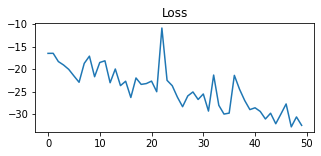

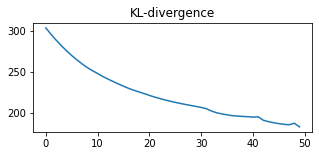

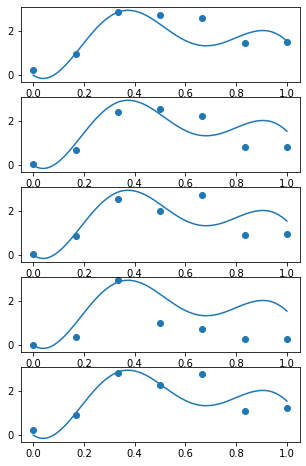

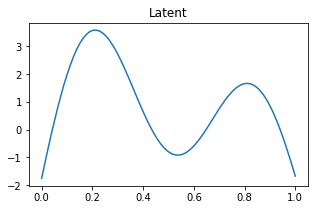

In [93]:
print(losses.shape)
plt.figure(figsize=(5, 2))
plt.plot(losses[50:, 0])
plt.title('Loss')
plt.figure(figsize=(5, 2))
plt.plot(losses[50:, 1])
plt.title('KL-divergence')

plot_genes()
plot_tfs()

(50,)
Parameter containing:
tensor([[0.3757],
        [0.0000],
        [0.0000],
        [0.1630],
        [0.0000]], dtype=torch.float64, requires_grad=True)


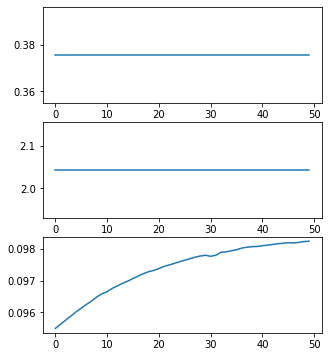

In [94]:
plt.figure(figsize=(5, 6))
_, basal, decay, lengthscale = params
basals = np.array(basal)
decays = np.array(decay)
lengthscales = np.array(lengthscale)
print(lengthscales.shape)
plt.subplot(311)
# print(basals[:,0])
plt.plot(basals[:,0])
# plt.ylim(1, 1.5)
plt.subplot(312)
plt.plot(decays[:,0])
# plt.ylim(0.5, 1)
plt.subplot(313)
plt.plot(lengthscales)
# plt.ylim(1, 1.2)

print(model.basal_rate)


In [95]:
model.sensitivity
# model.gp.covar_module.outputscale

Parameter containing:
tensor([[4.7775],
        [4.6807],
        [4.7744],
        [1.6959],
        [5.0448]], dtype=torch.float64, requires_grad=True)